In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings("ignore")
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn import model_selection
import time
from sklearn.neural_network import MLPRegressor
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
from sklearn.preprocessing import LabelEncoder
from time import time
from datetime import datetime
import json
import theano
import keras
import import_ipynb
from save_lib import save_RF_model
from save_lib import save_NN_model
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'c:\\Temp\\try_flags_gwxmeh_9.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)
Using TensorFlow backend.


importing Jupyter notebook from save_lib.ipynb


In [14]:
file_names[-2]

'table_stretching.xlsx'

In [15]:
dr = 'exp/prepared/'
file_names = os.listdir(dr)

def lowerstr(f):
    for col in f:
        if '№ партии' in col:
            f['№ партии'] = f['№ партии'].apply(lambda x: str(x))            
            f['№ партии'] = f['№ партии'].str.lower()
        if '№ плавки' in col:
            f['№ плавки'] = f['№ плавки'].str.lower()
    return f


df_modes = pd.read_excel('merge_table_mean_chem.xlsx')
table_stretching = pd.read_excel(dr+file_names[-2])
print(table_stretching.shape)
table_stretching = lowerstr(table_stretching)

(28908, 36)


In [16]:
table_stretching.shape

(28908, 36)

In [17]:
ls_all = [
    'Поставщик',
    'НД (гост, ту)',
    'ГОСТ, ТУ',
    'Дата форм. цехом',
    'марка стали',
    '№ плавки',
    'кол-во, шт.',
    '№ партии',
    '1 зона по ВТР закалка', 
    '1 зона уставка закалка',
    '1 зона фактическая температура закалка', 
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка', 
    '3 зона уставка закалка',
    '3 зона фактическая температура закалка',
    'Температура трубы на выгрузке из печи закалки',
    'Скорость прохождения трубы через спрейер, м/с',
    't˚ C трубы после спреера', 
    'Расход воды на закалочный спрейер, м3',
    'время выдержки в закалочной ванне, сек.',
    't˚ C воды в закалочной ванне', 
    't˚ C трубы после ванны',
    '1 зона ВТР и уставка отпуск', 
    '1 зона фактическая температура отпуск',
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '3 зона фактическая температура отпуск', 
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск', 
    '5 зона фактическая температура отпуск',
    'Температура трубы на выгрузке из печи отпуска',
    'шаг балок закалочная печь, сек', 
    'шаг балок отпускная печь, сек',
    'диаметр', 
    'толщина стенки', 
    'C', 
    'Mn', 
    'Si', 
    'P', 
    'S',
    'Cr', 
    'Ni', 
    'Cu', 
    'Al', 
    'V', 
    'Ti', 
    'Nb', 
    'Mo', 
    'N', 
    'B',
    'Параметр',
    'Тип предела текучести 0.2',
    'Тип предела текучести 0.5',
    'Тип предела текучести 0.6',
    'C-coef'
]

In [18]:
table_stretching.shape

(28908, 36)

In [19]:
df_merge = pd.merge(df_modes, table_stretching, how ='left', on = ['№ плавки','№ партии'])

chem = {#'Mn': 0, 'Si': 0, 
#         'P': 0, 
#         'Cr': 0, 'Ni': 0, 'Cu': 0, 'Al': 0, 'V': 0, 'Mo': 0, 
        'Ti': 0, 'Nb': 0, 'N': 0.004, 'B': 0.001, 'S': 0}

df_merge = df_merge.fillna(value = chem)

In [20]:
df_merge.shape

(28617, 82)

In [21]:
df_merge['Параметр закалка'] = 1/(1/((df_merge['2 зона по ВТР закалка']+
                                   df_merge['3 зона по ВТР закалка'])/2 + 273)
                                - (2.303*1.986*np.log10(61*df_merge['шаг балок закалочная печь, сек']/3600)/110000))-273
                               

In [22]:
df_merge['Параметр отпуск'] = ((df_merge['2 зона по ВТР закалка']+df_merge['4 зона ВТР и уставка отпуск']+df_merge['5 зона фактическая температура отпуск'])/3
                        + 273)*(20+np.log(94*df_merge['шаг балок отпускная печь, сек']/3600))*1e-3

In [23]:
df_merge['Тип предела текучести (1186)'] = df_merge['Тип предела текучести (1186)'].apply(lambda x: str(x))

In [24]:
# df_merge = df_merge[df_merge['Врем. сопротивление'] != '']
# df_merge = df_merge[df_merge['Предел текучести'] != '']
df_merge = df_merge[df_merge['t˚ C трубы после спреера'] != ' ']

In [25]:
df_merge.shape

(28608, 84)

In [26]:
df_merge.head()

,№ плавки,№ партии,"НД (гост, ту)",марка стали,"кол-во, шт.",1 зона по ВТР закалка,1 зона уставка закалка,1 зона фактическая температура закалка,2 зона по ВТР закалка,3 зона по ВТР закалка,3 зона уставка закалка,3 зона фактическая температура закалка,Температура трубы на выгрузке из печи закалки,"Скорость прохождения трубы через спрейер, м/с",t˚ C трубы после спреера,"Расход воды на закалочный спрейер, м3","время выдержки в закалочной ванне, сек.",t˚ C воды в закалочной ванне,t˚ C трубы после ванны,1 зона ВТР и уставка отпуск,1 зона фактическая температура отпуск,2 зона ВТР и уставка отпуск,3 зона ВТР и уставка отпуск,3 зона фактическая температура отпуск,4 зона ВТР и уставка отпуск,5 зона ВТР и уставка отпуск,5 зона фактическая температура отпуск,Температура трубы на выгрузке из печи отпуска,"шаг балок закалочная печь, сек","шаг балок отпускная печь, сек",диаметр,толщина стенки,Поставщик,C,Mn,Si,P,S,Cr,Ni,Cu,Al,V,Ti,Nb,Mo,N,B,Тип предела текучести (1186),Дата форм. цехом,№ заявки,"ГОСТ, ТУ",Гр. прочн.,Марка стали,Диаметр,Стенка,Предел текучести (1027),Относительное удлинение (1099),Врем. сопротивление (1042),Отношение (1118),Относительное сужение (1016),Предел текучести (1141),Врем. сопротивление (1140),Диаметр образца (1225),Толщина (1226),min Предел текучести (1027),max Предел текучести (1027),min Относительное удлинение (1099),min Врем. сопротивление (1042),max Врем. сопротивление (1042),max Отношение (1118),"Предел текучести, Ksi (1145)","Врем. сопротивление, Ksi (1146)","Предел текучести, кгс/мм2","Врем. сопротивление, кгс/мм2","Предел текучести, Н/мм2 или МПа","Врем. сопротивление, Н/мм2 или МПа","Предел текучести , кгс/мм2","Врем. сопротивление , кгс/мм2","Тип предела текучести, Н/мм2 или МПа",Врем. сопротивление,Предел текучести,Параметр закалка,Параметр отпуск
0,10034,305311,ТУ 3,38Г2С,50,860.0,860.0,861.0,860.0,870.0,853.0,853.0,861.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,604.0,605.0,597.0,599.0,597.0,584.0,584.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.38,1.72,0.49,0.011,0.009,0.06,0.03,0.04,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,431972.0,ГОСТ 633-80 Исполнение А,Д,38Г2С,73.00,5.5,40.0,26.5,76.5,0.52,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.5,40.0,849.393849,18.833866
1,10035,305309,ТУ 3,38Г2С,50,860.0,860.0,865.0,860.0,870.0,853.0,852.0,861.0,1.0,NaN,117.0,NaN,27.0,NaN,605.0,607.0,605.0,597.0,596.0,597.0,584.0,585.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.39,1.64,0.46,0.009,0.006,0.05,0.03,0.07,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,431968.0,ГОСТ 633-80 Исполнение А,Д,38Г2С,73.00,5.5,39.0,24.0,78.0,0.50,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,39.0,849.393849,18.840451
2,10043,202198,ту78,30Г2,20,890.0,890.0,891.0,890.0,900.0,900.0,901.0,898.0,1.0,NaN,1813.0,30.0,23.0,25.0,520.0,522.0,525.0,517.0,515.0,522.0,517.0,517.0,524.0,39.0,39.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.004,0.001,0.2,15.02.2012,407998.0,ГОСТ 633-80,Л,30Г2,107.95,14.0,71.5,16.5,86.5,0.83,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5,71.5,884.883303,18.336641
3,10043,402040,ТУ 78,30Г2,15,900.0,900.0,900.0,900.0,910.0,908.0,908.0,895.0,1.0,NaN,37.0,NaN,23.0,42.5,570.0,569.0,570.0,564.0,563.0,564.0,555.0,555.0,558.0,36.0,36.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.004,0.001,0.2,03.02.2014,442750.0,ГОСТ 633-80 Исполнение А,К,30Г2,107.95,14.0,65.0,20.0,81.0,0.80,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,65.0,892.742550,18.861466
4,10050,305312,ТУ 3,38Г2С,28,860.0,860.0,861.0,860.0,870.0,853.0,853.0,860.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,606.0,605.0,597.0,596.0,597.0,584.0,583.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.37,1.67,0.51,0.013,0.007,0.05,0.03,0.04,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,431974.0,ГОСТ 633-80 Исполнение А,Д,

In [27]:
ls_type = [
    'Тип предела текучести 0.2',
    'Тип предела текучести 0.5',
    'Тип предела текучести 0.6',
    'del'
]
df_merge[ls_type] = pd.get_dummies(df_merge['Тип предела текучести (1186)'])

In [28]:
ls_steel = pd.get_dummies(df_merge['марка стали']).columns
ls_steel = list(ls_steel)

In [29]:
len(ls_steel)

66

In [30]:
df_merge[ls_steel] = pd.get_dummies(df_merge['марка стали'])

In [31]:
df_merge.shape

(28608, 154)

In [32]:
df_merge = df_merge.reset_index(drop=True)

In [33]:
df_merge.head()

,№ плавки,№ партии,"НД (гост, ту)",марка стали,"кол-во, шт.",1 зона по ВТР закалка,1 зона уставка закалка,1 зона фактическая температура закалка,2 зона по ВТР закалка,3 зона по ВТР закалка,3 зона уставка закалка,3 зона фактическая температура закалка,Температура трубы на выгрузке из печи закалки,"Скорость прохождения трубы через спрейер, м/с",t˚ C трубы после спреера,"Расход воды на закалочный спрейер, м3","время выдержки в закалочной ванне, сек.",t˚ C воды в закалочной ванне,t˚ C трубы после ванны,1 зона ВТР и уставка отпуск,1 зона фактическая температура отпуск,2 зона ВТР и уставка отпуск,3 зона ВТР и уставка отпуск,3 зона фактическая температура отпуск,4 зона ВТР и уставка отпуск,5 зона ВТР и уставка отпуск,5 зона фактическая температура отпуск,Температура трубы на выгрузке из печи отпуска,"шаг балок закалочная печь, сек","шаг балок отпускная печь, сек",диаметр,толщина стенки,Поставщик,C,Mn,Si,P,S,Cr,Ni,Cu,Al,V,Ti,Nb,Mo,N,B,Тип предела текучести (1186),Дата форм. цехом,...,18ХМФБ,18ХМФБ-в2,20,20А,20А-1,20А-У,20А-пр,20Г2,20Г2-1,20ФА,20ХМФА,20ХФА,26Г1ФМ,30Г2,30Г2,30Г2-2,30Г2-3,30Г2-5,30Г2-8,30Г2Ф,30Г3,30ХГМА,30ХГМА-1,30ХГМА-4,30ХГСА,30ХМА,32Г1,32Г2,32Г2СФБ,32Х1МФ,32Х1МФ-1,32ХА,32ХГ,32ХНМ,35ХМФA,36ХГ2СФБ,36ХГФ,37Г2С,37Г2Ф,37Г2Ф-М,38Г2-4,38Г2С,38Г2С-1,38Г2С-3,38Г2С-4,38Г2С-9,38Г2С-В,38Г2СФ,Д,ДБ
0,10034,305311,ТУ 3,38Г2С,50,860.0,860.0,861.0,860.0,870.0,853.0,853.0,861.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,604.0,605.0,597.0,599.0,597.0,584.0,584.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.38,1.72,0.49,0.011,0.009,0.06,0.03,0.04,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,10035,305309,ТУ 3,38Г2С,50,860.0,860.0,865.0,860.0,870.0,853.0,852.0,861.0,1.0,NaN,117.0,NaN,27.0,NaN,605.0,607.0,605.0,597.0,596.0,597.0,584.0,585.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.39,1.64,0.46,0.009,0.006,0.05,0.03,0.07,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,10043,202198,ту78,30Г2,20,890.0,890.0,891.0,890.0,900.0,900.0,901.0,898.0,1.0,NaN,1813.0,30.0,23.0,25.0,520.0,522.0,525.0,517.0,515.0,522.0,517.0,517.0,524.0,39.0,39.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.004,0.001,0.2,15.02.2012,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10043,402040,ТУ 78,30Г2,15,900.0,900.0,900.0,900.0,910.0,908.0,908.0,895.0,1.0,NaN,37.0,NaN,23.0,42.5,570.0,569.0,570.0,564.0,563.0,564.0,555.0,555.0,558.0,36.0,36.0,107.95,14.0,"АО ""ОЭМК""",0.28,1.32,0.25,0.008,0.007,0.05,0.03,0.04,0.027,0.002,0.0012,0.0,0.007,0.004,0.001,0.2,03.02.2014,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10050,305312,ТУ 3,38Г2С,28,860.0,860.0,861.0,860.0,870.0,853.0,853.0,860.0,1.0,NaN,116.0,NaN,27.0,NaN,605.0,606.0,605.0,597.0,596.0,597.0,584.0,583.0,582.0,30.0,30.0,73.00,5.5,"АО ""ОЭМК""",0.37,1.67,0.51,0.013,0.007,0.05,0.03,0.04,NaN,NaN,0.0000,0.0,NaN,0.004,0.001,0.2,27.05.2013,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [34]:
df_merge = df_merge[df_merge['Cr'] < 10]

In [35]:
df_merge['C-coef'] = ((df_merge['C'] + df_merge['Mn'])/6.0 + (df_merge['Cr'] + df_merge['Mo'] + df_merge['V'])/5.0 +
                        (df_merge['Ni'] + df_merge['Cu'])/15.0)

In [36]:
df_merge.shape

(28561, 155)

In [37]:
df_merge.to_excel('prepared_hard.xlsx')

In [38]:
df_merge = pd.read_excel('prepared_hard.xlsx')
df_merge.shape

(28561, 155)

In [40]:
ls_need_col = [
#     'Поставщик',
#     'НД (гост, ту)',
#     'ГОСТ, ТУ',
#     'Дата форм. цехом',
     'марка стали',
#     '№ плавки',
#     'кол-во, шт.',
#     '№ партии',
    '1 зона по ВТР закалка', 
#     '1 зона уставка закалка',
#     '1 зона фактическая температура закалка', 
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка', 
#     '3 зона уставка закалка',
#     '3 зона фактическая температура закалка',
    'Температура трубы на выгрузке из печи закалки',
    'Скорость прохождения трубы через спрейер, м/с',
    't˚ C трубы после спреера', 
#     'Расход воды на закалочный спрейер, м3',
#     'время выдержки в закалочной ванне, сек.',
#     't˚ C воды в закалочной ванне', 
#     't˚ C трубы после ванны',
    '1 зона ВТР и уставка отпуск', 
#     '1 зона фактическая температура отпуск',
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
#     '3 зона фактическая температура отпуск', 
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск', 
#     '5 зона фактическая температура отпуск',
    'Температура трубы на выгрузке из печи отпуска',
    'шаг балок закалочная печь, сек', 
    'шаг балок отпускная печь, сек',
    'диаметр', 
    'толщина стенки', 
    'C', 
    'Mn', 
    'Si', 
    'P', 
#     'S',
    'Cr', 
    'Ni', 
    'Cu', 
    'Al', 
#     'V', 
#     'Ti', 
#     'Nb', 
#     'Mo', 
    'N', 
#     'B',
    'Параметр отпуск',
    'Параметр закалка',
    'Тип предела текучести 0.2',
    'Тип предела текучести 0.5',
    'Тип предела текучести 0.6',
    'C-coef'
]

df_prepared_merge = pd.DataFrame()

for col in ls_need_col+['Предел текучести', 'Врем. сопротивление']: #ls_steel
    df_prepared_merge[col] = df_merge[col]

In [101]:
# df_prepared_merge['НД (гост, ту)'] = df_prepared_merge['НД (гост, ту)'].apply(lambda x: str(x))

In [41]:
label = LabelEncoder()  
# print(df_prepared_merge['марка стали'])
df_prepared_merge['марка стали'] = label.fit_transform(df_prepared_merge['марка стали'])
# df_prepared_merge['НД (гост, ту)'] = label.fit_transform(df_prepared_merge['НД (гост, ту)'])
# print(df_prepared_merge['марка стали'])

In [103]:
# df_prepared_merge = df_prepared_merge[df_prepared_merge['t˚ C трубы после спреера'] != ' ']

In [42]:
df_prepared_merge = df_prepared_merge.dropna()
df_prepared_merge.shape

(14888, 34)

In [43]:
# Посмотреть все ли в кгс (если max чуть больше 100, то все ок, если 800 или больше у нас конкретные проблемы)
print(df_prepared_merge['Предел текучести'].describe())
print(df_prepared_merge['Врем. сопротивление'].describe())

count    14888.000000
mean        64.783628
std         20.305754
min         25.000000
25%         62.000000
50%         66.740426
75%         70.500000
max        775.500000
Name: Предел текучести, dtype: float64
count    14888.000000
mean        75.036206
std         21.166231
min         38.500000
25%         72.500000
50%         76.000000
75%         80.000000
max        811.500000
Name: Врем. сопротивление, dtype: float64


In [106]:
import seaborn as sns

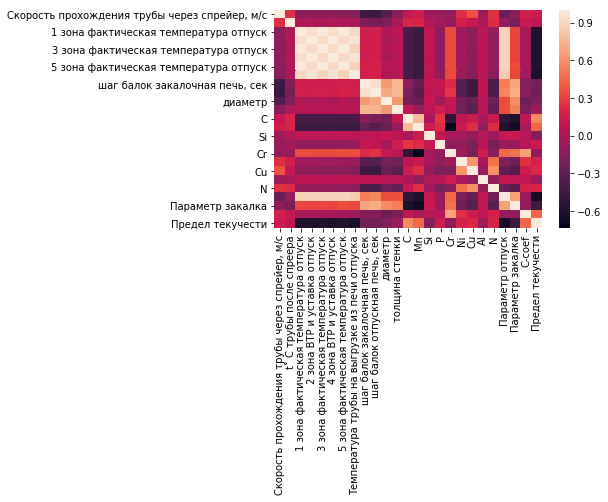

In [107]:
#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
corr_matrix = df_merge[ls_need_col+['Предел текучести']].corr()
sns_corr = sns.heatmap(corr_matrix).get_figure()
sns_corr.savefig('corr_прочность.png')

In [6]:
df_prepared_merge = df_prepared_merge.reset_index(drop=True)

In [7]:
df_prepared_merge.shape

(15892, 26)

In [8]:
y = pd.DataFrame()
X = pd.DataFrame()

target = 'Предел текучести'
# target = 'Врем. сопротивление'

y[target] = df_prepared_merge[target]


for i in ls_need_col: #+ls_steel:
    X[i] = df_prepared_merge[i]

In [9]:
X['C'].describe()

count    15892.000000
mean         0.248092
std          0.060691
min          0.050000
25%          0.190000
50%          0.280000
75%          0.290000
max          0.400000
Name: C, dtype: float64

In [112]:
X['C'].value_counts().index

Float64Index([  0.28,   0.29,   0.27,    0.3,   0.17,   0.14,   0.31,   0.18,
                0.15,   0.16,
              ...
               0.212,  0.185,  0.278, 0.2895,  0.186,  0.197,  0.279,  0.178,
               0.292,  0.183],
             dtype='float64', length=151)

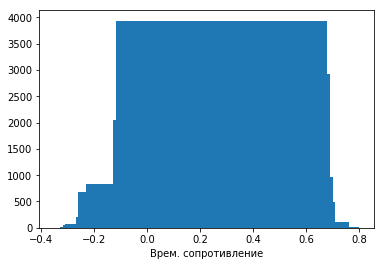

In [113]:
# for col in X:
#     x = X[col].value_counts().index
#     y = X[col].value_counts().values
#     plt.bar(x, y)
#     plt.xlabel(col)
#     plt.show()



# Хотела посмотреть что не так с осью и подписями на ней
x = X['C'].value_counts().index
y_pl = X['C'].value_counts().values
plt.bar(x, y_pl)
plt.xlabel(col)
plt.show()

# x = X['C'].value_counts().index
# y = X['C'].value_counts().values
# plt.bar(x, y)
# plt.xlabel('C')
# plt.show()
# X['C'].describe()

In [114]:
# for col in y:
#     xp = y[col].value_counts().index
#     yp = y[col].value_counts().values
#     plt.bar(xp, yp)
#     plt.xlabel(col)
#     plt.show()

In [115]:
tmp = pd.DataFrame()
# for col in X.columns[:1]:
tmp = X[X['2 зона по ВТР закалка'] != (np.median(X['2 зона по ВТР закалка'])+50)]
for col in tmp:
    x = tmp[col].value_counts().index
    y_pl = tmp[col].value_counts().values
    plt.bar(x, y_pl)
    plt.xlabel(col)
    plt.show()

KeyError: '2 зона по ВТР закалка'

In [116]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=7)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [148]:
np.array(y).reshape(19545,)

array([ 77.5       ,  47.        ,  44.5       , ...,  67.40324168,
        67.5052133 ,  67.09732681])

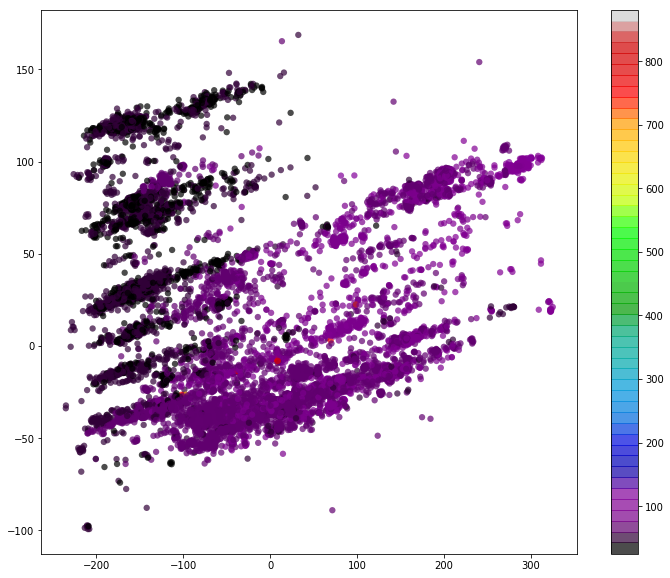

In [178]:
pca = decomposition.PCA(n_components=7)
X_reduced = pca.fit_transform(X)
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.array(y).reshape(19545,),
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 50))
plt.colorbar()
plt.show()

In [163]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.array(y).reshape(19545,), 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

KeyboardInterrupt: 

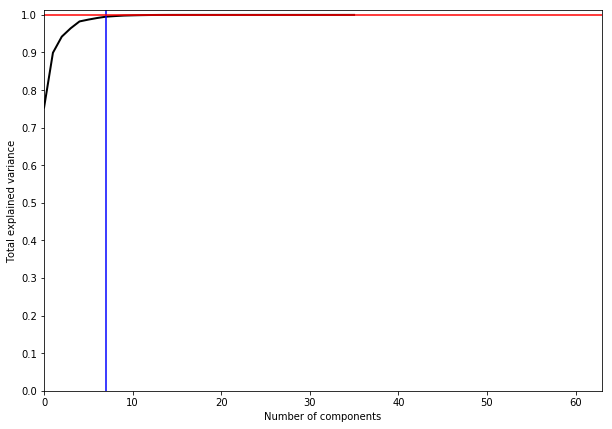

In [177]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(7, c='b')
plt.axhline(1, c='r')
plt.show();

In [10]:
scalerx = StandardScaler()  
X = scalerx.fit_transform(X, y)

In [11]:
print(X.shape,y.shape)

(15892, 24) (15892, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12713, 24), (12713, 1), (3179, 24), (3179, 1))

array([[ 0.63063311, -0.92184997,  0.58433489, ...,  0.23016612,
        -0.539308  , -0.36378998],
       [ 0.73943272,  1.58545826, -0.12912251, ..., -0.6538738 ,
        -0.66102608,  0.2719127 ],
       [ 0.30423429, -0.83335674, -0.19600914, ..., -0.36636194,
        -0.539308  , -0.29992495],
       ...,
       [-2.14375686, -1.24632516,  1.654521  , ...,  2.26800742,
         1.37784415, -1.58115571],
       [-0.62056237, -0.62687253,  1.45386111, ...,  1.81179161,
         2.03979443, -1.25053136],
       [-1.65415863, -1.06933869, -2.13572147, ..., -1.09346227,
         1.49336942,  1.80663851]])

In [15]:
rfc = RandomForestRegressor(max_features = 10, max_depth = 15, min_samples_leaf = 2, n_estimators=500, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
scr = rfc.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
corr = np.corrcoef(y_test.T, y_pred)
print(scr, mae, mse, corr)


# Сохраняем информацию о качестве модели
score_data = {
    'r square':[scr],
    'MAE':[mae],
    'MSE':[mse],
    'corr':[corr[0][1]]
}
score_df = pd.DataFrame(data = score_data)
# score_df

# Вызов метода из скрипта save_lib который создает папку в MODEL_RF 
# с текущим временем и сохраняет туда всю информацию по модели и саму модель
save_RF_model(rfc, ls_need_col, target, score_df)

0.9063467048987801 2.4225452372359544 11.957416930952222 [[1.       0.952053]
 [0.952053 1.      ]]
Модель сохранена


In [194]:
# rfc.feature_importances_

In [17]:
etr = ExtraTreesRegressor()
etr.fit(X_train, y_train)
print(etr.feature_importances_)

[0.02617374 0.02690658 0.02191774 0.03432448 0.02851517 0.08670277
 0.0141696  0.01997791 0.01007294 0.03829479 0.06685443 0.0170711
 0.0505021  0.03524299 0.01258992 0.00456742 0.07453796 0.00709817
 0.0068795  0.00460046 0.00927914 0.16469587 0.08643032 0.15259489]


In [20]:
etr.predict(df)*9.8

array([603.19271816, 555.01906492, 555.01906492])

In [21]:
tmp = pd.DataFrame()
for col in ls_need_col: #+ls_steel:
    tmp[col] = df_prepared_merge[col]

In [22]:
len(etr.feature_importances_), len(tmp.columns)

(24, 24)

In [23]:
a = sorted(zip(rfc.feature_importances_, tmp.columns))

In [24]:
for i, j in a:
    print(i,j)

0.00245419019072679 Al
0.002834464234587778 P
0.00284060253921088 шаг балок отпускная печь, сек
0.003197294164937042 шаг балок закалочная печь, сек
0.0039946075777344625 N
0.004203101807150906 5 зона фактическая температура отпуск
0.004370460416600907 Cu
0.006169019202127517 толщина стенки
0.006385883391592517 Скорость прохождения трубы через спрейер, м/с
0.0069122528197074476 3 зона фактическая температура отпуск
0.006935911613972258 Si
0.007180862563049319 Ni
0.007944301854169292 1 зона фактическая температура отпуск
0.011192029545135304 t˚ C трубы после спреера
0.012141208695637647 диаметр
0.027540513284154307 Mn
0.0316380526416954 Температура трубы на выгрузке из печи отпуска
0.03473071189136531 Cr
0.054007110190228136 2 зона ВТР и уставка отпуск
0.05880073757741377 4 зона ВТР и уставка отпуск
0.06083583420963006 Параметр закалка
0.11205778973874161 Параметр отпуск
0.1776729870618776 C
0.35396007278855357 C-coef


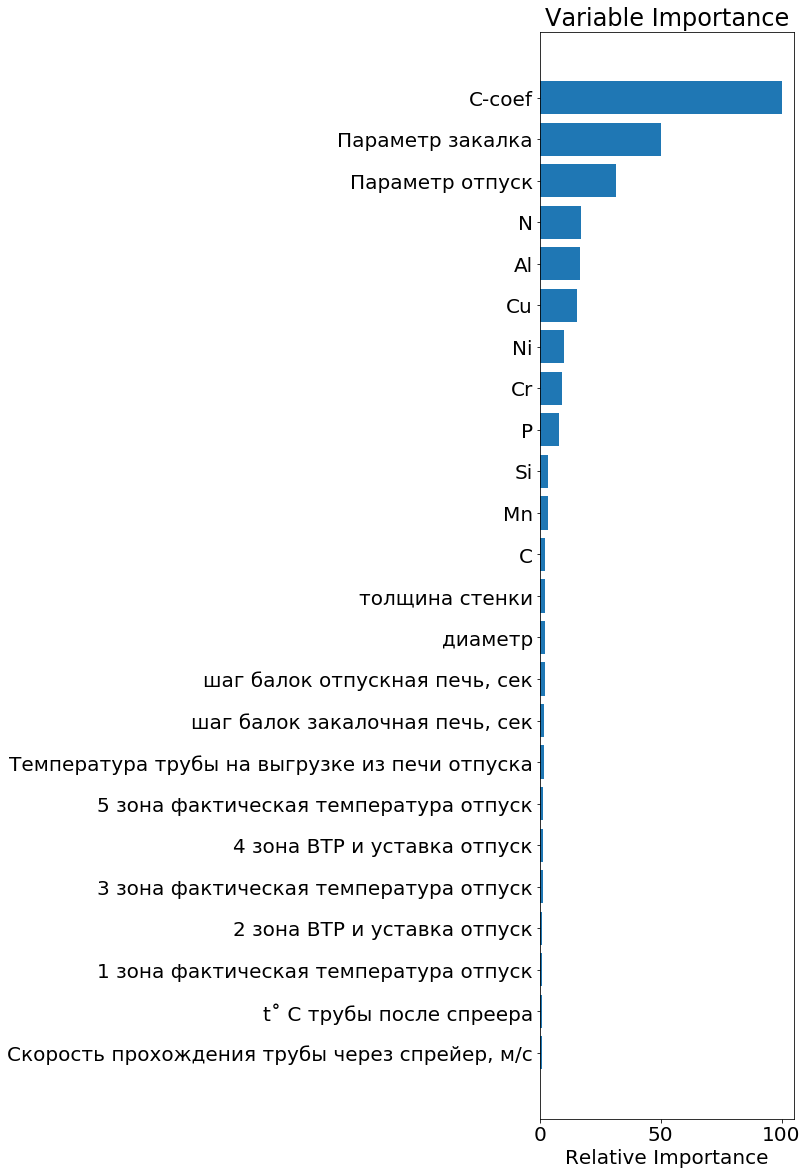

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline


# plt.scatter(etr.feature_importances_, tmp.columns)

feature_importance = rfc.feature_importances_
#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 20
rcParams.update({'font.size': 20})

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 2
plt.subplot(1, 2, 2)
plt.barh(pos,feature_importance[sorted_idx], align='center')
plt.yticks(pos, tmp.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('feature_importance.png')
plt.show()


In [228]:
a = sorted(zip(fit.ranking_, tmp.columns))
for i, j in a:
    print(i,j)

1 C-coef
1 Параметр
1 шаг балок закалочная печь, сек
2 Cu
3 1 зона фактическая температура отпуск
4 C
5 t˚ C трубы после спреера
6 2 зона ВТР и уставка отпуск
7 3 зона уставка закалка
8 V
9 Температура трубы на выгрузке из печи отпуска
10 N
11 Si
12 Mn
13 1 зона уставка закалка
14 Nb
15 Скорость прохождения трубы через спрейер, м/с
16 толщина стенки
17 Cr
18 P
19 Ni
20 S
21 диаметр
22 шаг балок отпускная печь, сек
23 Mo
24 Ti
25 Al
26 B


In [232]:
from sklearn.feature_selection import RFE

etr = ExtraTreesRegressor()

rfe = RFE(etr, 3, verbose=1)

fit = rfe.fit(X_train, y_train)

print(fit.n_features_)

print(fit.support_)

print(fit.ranking_)

Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
3
[False False False False False False False  True False False False False
 False False False False False 

In [225]:
print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

3
[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False  True  True]
[13  7 15  5  3  6  9  1 22 21 16  4 12 11 18 20 17 19  2 25  8 24 14 23 10
 26  1  1]


In [276]:
# cv = cross_val_score(rfc, X, y, cv=5, scoring = 'neg_median_absolute_error')

In [277]:
# np.mean(cv)

In [305]:
# predicted = cross_val_predict(rfc, X, y, cv=5)

In [306]:
# mae = mean_absolute_error(y, predicted)
# mae

In [155]:
mae*9.8

29.316895263172619

In [273]:
'''
Подбор параметров деревьев решений
'''
from sklearn.model_selection import GridSearchCV

tree = RandomForestRegressor()

tree_params = {'max_depth': range(5,15, 5),'max_features': range(10,20),  
               'min_samples_leaf': range(1,4), 'n_estimators': range(100,1000, 300)}

tree_grid = GridSearchCV(tree, tree_params,cv=5, verbose = True, n_jobs=-1)

tree_grid.fit(X_train, y_train)
y_pred_grid = tree_grid.predict(X_test)
print(tree_grid.best_params_)
print(tree_grid.best_score_)
print(mean_absolute_error(y_test, y_pred_grid))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 17.2min finished


{'max_depth': 10, 'max_features': 13, 'min_samples_leaf': 1, 'n_estimators': 400}
0.898387465771
2.49103460966


In [19]:
d = {
#     'НД (гост, ту)' : [ ]
#     'марка стали' : [35, 52, 27], #'30ХГМА', '37Г2Ф', '30Г2'
#     '1 зона фактическая температура закалка' : [860, 840, 850], 
#     '2 зона по ВТР закалка' : [860, 840, 850],
#     '3 зона по ВТР закалка' : [860, 850, 860], 
#     'Температура трубы на выгрузке из печи закалки' : [855, 835, 850],
    'Скорость прохождения трубы через спрейер, м/с' : [0.15, 0.28, 0.37],
    't˚ C трубы после спреера' : [106, 100, 75],
    '1 зона ВТР и уставка отпуск' : [675, 664, 600], 
    '2 зона ВТР и уставка отпуск' : [675, 664, 600], 
    '3 зона ВТР и уставка отпуск' : [650, 653, 593],
    '4 зона ВТР и уставка отпуск' : [650, 653, 593],
    '5 зона ВТР и уставка отпуск' : [633, 637, 580], 
    'Температура трубы на выгрузке из печи отпуска' : [660, 660, 575],
    'шаг балок закалочная печь, сек' : [37, 40, 30], 
    'шаг балок отпускная печь, сек' : [37, 31, 30],
    'диаметр' : [187.71, 88.9, 168.28], 
    'толщина стенки' : [16.5, 12.2, 8.94], 
    'C' : [0.29, 0.37, 0.28], 
    'Mn' : [0.92, 1.49, 1.33], 
    'Si' : [0.26, 0.28, 0.26], 
    'P' : [0.009, 0.011, 0.009], 
#     'S' : [0.005, 0.007, 0.007],
    'Cr' : [0.68, 0.14, 0.1], 
    'Ni' : [0.13, 0.13, 0.13], 
    'Cu' : [0.15, 0.13, 0.19], 
    'Al' : [0.03, 0.03, 0.03], 
#     'V' : [0.007, 0.09, 0.005], 
#     'Ti' : [0, 0.006, 0.007], 
#     'Nb' : [0, 0.0002, 0.006], 
#     'Mo' : [0.16, 0.0009, 0.015], 
    'N' : [0.008, 0.006, 0.009], 
#     'B': [0, 0, 0.0005],
    'Параметр отпуск' : [25.826798, 25.757751, 24.078837],
    'Параметр закалка' : [849.279448, 836.289772, 839.665069],
#     'Тип предела текучести 0.2': [1, 1, 1],
#     'Тип предела текучести 0.5': [0, 0, 0],
#     'Тип предела текучести 0.6': [0, 0, 0],
    'C-coef': [0.39, 0.37, 0.31],
#     '08ХГМФБ': [0, 0, 0],
#     '08ХГФБ': [0, 0, 0],
#     '09Г2С': [0, 0, 0],
#     '09ГФБ': [0, 0, 0],
#     '10Г2': [0, 0, 0],
#     '10Х1МФБ': [0, 0, 0],
#     '12ГА': [0, 0, 0],
#     '12ГФ': [0, 0, 0],
#     '13ГФА': [0, 0, 0],
#     '13ХФА': [0, 0, 0],
#     '13ХФА-3': [0, 0, 0],
#     '13ХФА-4': [0, 0, 0],
#     '15Х5МФБЧ': [0, 0, 0],
#     '18ГФ': [0, 0, 0],
#     '18Х3МФБ': [0, 0, 0],
#     '18ХГТ': [0, 0, 0],
#     '18ХМФБ': [0, 0, 0],
#     '18ХМФБ-в2': [0, 0, 0],
#     '20': [0, 0, 0],
#     '20А': [0, 0, 0],
#     '20А-1': [0, 0, 0],
#     '20А-У': [0, 0, 0],
#     '20А-пр': [0, 0, 0],
#     '20Г2': [0, 0, 0],
#     '20Г2-1': [0, 0, 0],
#     '20ФА': [0, 0, 0],
#     '20ХМФА': [0, 0, 0],
#     '20ХФА': [0, 0, 0],
#     '26Г1ФМ': [0, 0, 0],
#     '30Г2': [0, 0, 1],
#     '30Г2 ': [0, 0, 0],
#     '30Г2-2': [0, 0, 0],
#     '30Г2-3': [0, 0, 0],
#     '30Г2-5': [0, 0, 0],
#     '30Г2-8': [0, 0, 0],
#     '30Г2Ф': [0, 0, 0],
#     '30Г3': [0, 0, 0],
#     '30ХГМА': [1, 0, 0],
#     '30ХГМА-1': [0, 0, 0],
#     '30ХГМА-4': [0, 0, 0],
#     '30ХГСА': [0, 0, 0],
#     '30ХМА': [0, 0, 0],
#     '32Г1': [0, 0, 0],
#     '32Г2': [0, 0, 0],
#     '32Г2СФБ': [0, 0, 0],
#     '32Х1МФ': [0, 0, 0],
#     '32Х1МФ-1': [0, 0, 0],
#     '32ХА': [0, 0, 0],
#     '32ХГ': [0, 0, 0],
#     '32ХНМ': [0, 0, 0],
#     '35ХМФA': [0, 0, 0],
#     '36ХГ2СФБ': [0, 0, 0],
#     '36ХГФ': [0, 0, 0],
#     '37Г2С': [0, 0, 0],
#     '37Г2Ф': [0, 1, 0],
#     '37Г2Ф-М': [0, 0, 0],
#     '38Г2-4': [0, 0, 0],
#     '38Г2С': [0, 0, 0],
#     '38Г2С-1': [0, 0, 0],
#     '38Г2С-3': [0, 0, 0],
#     '38Г2С-4': [0, 0, 0],
#     '38Г2С-9': [0, 0, 0],
#     '38Г2С-В': [0, 0, 0],
#     '38Г2СФ': [0, 0, 0],
#     'Д': [0, 0, 0],
#     'ДБ': [0, 0, 0]
}

df = pd.DataFrame(data = d)

In [346]:
time()

1522057298.1167452

In [338]:
import pickle

s = pickle.dumps(rfc)
rfc2 = pickle.loads(s)
y = rfc2.predict(df)
print(y*9.8)

[ 579.39271318  580.72972999  580.72762136]


In [339]:
y[0]

59.121705426057488

In [323]:
s = pickle.dumps(tree_grid)
rfc2 = pickle.loads(s)
y = rfc2.predict(df)
print(y*9.8)

ValueError: Number of features of the model must match the input. Model n_features is 23 and input n_features is 21 

In [96]:
import theano

RuntimeError: To use MKL 2018 with Theano you MUST set "MKL_THREADING_LAYER=GNU" in your environement.

In [47]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization


kfold = model_selection.KFold(n_splits=5, random_state=17)

model = Sequential()
model.add(Dense(units=3, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.3))
# model.add(Dense(units=4))
# model.add(Activation('tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(units=4))
# model.add(Activation('sigmoid'))

model.add(Dense(units=1))

model.compile(
    loss=keras.losses.mean_squared_error,
    # loss=keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_squared_error],
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=1e-1)
    )

model.fit(X_train, y_train, batch_size = 512, epochs=700)


from scipy.stats.stats import pearsonr
y_predict = model.predict(X_test)
mae = mean_absolute_error(y_predict, y_test)
mse = mean_squared_error(y_predict, y_test)
corr = pearsonr(y_predict, y_test)
print(mae, mse, corr[0][0])
score_data = {
    'MSE':mse,
    'MAE':mae,
    'corr':corr[0][0]
}
save_NN_model(model, ls_need_col, target, score_df)
# cv_results = model_selection.cross_val_score(svr,X_train, np.ravel(y_train), cv=kfold, scoring='r2')

Epoch 1/700
12713/12713 [==============================] - 0s 6us/step - loss: 1204.0560 - mean_squared_error: 1204.0560
Epoch 2/700
12713/12713 [==============================] - 0s 3us/step - loss: 95.3014 - mean_squared_error: 95.3014
Epoch 3/700
12713/12713 [==============================] - 0s 2us/step - loss: 53.6821 - mean_squared_error: 53.6821
Epoch 4/700
12713/12713 [==============================] - 0s 3us/step - loss: 44.1610 - mean_squared_error: 44.1610
Epoch 5/700
12713/12713 [==============================] - 0s 2us/step - loss: 40.6298 - mean_squared_error: 40.6298
Epoch 6/700
12713/12713 [==============================] - 0s 2us/step - loss: 38.9368 - mean_squared_error: 38.9368
Epoch 7/700
12713/12713 [==============================] - 0s 3us/step - loss: 37.9954 - mean_squared_error: 37.9954
Epoch 8/700
12713/12713 [==============================] - 0s 2us/step - loss: 37.4099 - mean_squared_error: 37.4099
Epoch 9/700
12713/12713 [==============================] - 0

12713/12713 [==============================] - 0s 2us/step - loss: 32.8555 - mean_squared_error: 32.8555
Epoch 71/700
12713/12713 [==============================] - 0s 3us/step - loss: 32.8243 - mean_squared_error: 32.8243
Epoch 72/700
12713/12713 [==============================] - 0s 3us/step - loss: 32.7939 - mean_squared_error: 32.7939
Epoch 73/700
12713/12713 [==============================] - ETA: 0s - loss: 33.6467 - mean_squared_error: 33.64 - 0s 3us/step - loss: 32.7637 - mean_squared_error: 32.7637
Epoch 74/700
12713/12713 [==============================] - 0s 3us/step - loss: 32.7344 - mean_squared_error: 32.7344
Epoch 75/700
12713/12713 [==============================] - 0s 3us/step - loss: 32.7059 - mean_squared_error: 32.7059
Epoch 76/700
12713/12713 [==============================] - ETA: 0s - loss: 33.9818 - mean_squared_error: 33.98 - 0s 3us/step - loss: 32.6774 - mean_squared_error: 32.6774
Epoch 77/700
12713/12713 [==============================] - 0s 3us/step - loss:

12713/12713 [==============================] - 0s 3us/step - loss: 30.9706 - mean_squared_error: 30.9706
Epoch 205/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.9631 - mean_squared_error: 30.9631
Epoch 206/700
12713/12713 [==============================] - 0s 2us/step - loss: 30.9558 - mean_squared_error: 30.9558
Epoch 207/700
12713/12713 [==============================] - 0s 2us/step - loss: 30.9484 - mean_squared_error: 30.9484
Epoch 208/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.9411 - mean_squared_error: 30.9411
Epoch 209/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.9337 - mean_squared_error: 30.9337
Epoch 210/700
12713/12713 [==============================] - 0s 2us/step - loss: 30.9265 - mean_squared_error: 30.9265
Epoch 211/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.9192 - mean_squared_error: 30.9192
Epoch 212/700
12713/12713 [==============================] - 0

12713/12713 [==============================] - 0s 2us/step - loss: 30.5319 - mean_squared_error: 30.5319
Epoch 273/700
12713/12713 [==============================] - 0s 2us/step - loss: 30.5263 - mean_squared_error: 30.5263
Epoch 274/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.5207 - mean_squared_error: 30.5207
Epoch 275/700
12713/12713 [==============================] - 0s 2us/step - loss: 30.5151 - mean_squared_error: 30.5151
Epoch 276/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.5095 - mean_squared_error: 30.5095
Epoch 277/700
12713/12713 [==============================] - 0s 2us/step - loss: 30.5039 - mean_squared_error: 30.5039
Epoch 278/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.4984 - mean_squared_error: 30.4984
Epoch 279/700
12713/12713 [==============================] - 0s 3us/step - loss: 30.4928 - mean_squared_error: 30.4928
Epoch 280/700
12713/12713 [==============================] - 0

12713/12713 [==============================] - 0s 3us/step - loss: 29.9005 - mean_squared_error: 29.9005
Epoch 409/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.8966 - mean_squared_error: 29.8966
Epoch 410/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.8927 - mean_squared_error: 29.8927
Epoch 411/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.8889 - mean_squared_error: 29.8889
Epoch 412/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.8851 - mean_squared_error: 29.8851
Epoch 413/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.8812 - mean_squared_error: 29.8812
Epoch 414/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.8774 - mean_squared_error: 29.8774
Epoch 415/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.8736 - mean_squared_error: 29.8736
Epoch 416/700
12713/12713 [==============================] - 0

12713/12713 [==============================] - 0s 3us/step - loss: 29.4482 - mean_squared_error: 29.4482
Epoch 544/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.4453 - mean_squared_error: 29.4453
Epoch 545/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.4425 - mean_squared_error: 29.4425
Epoch 546/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.4396 - mean_squared_error: 29.4396
Epoch 547/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.4367 - mean_squared_error: 29.4367
Epoch 548/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.4338 - mean_squared_error: 29.4338
Epoch 549/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.4310 - mean_squared_error: 29.4310
Epoch 550/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.4281 - mean_squared_error: 29.4281
Epoch 551/700
12713/12713 [==============================] - 0

Epoch 680/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.0985 - mean_squared_error: 29.0985
Epoch 681/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.0962 - mean_squared_error: 29.0962
Epoch 682/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.0940 - mean_squared_error: 29.0940
Epoch 683/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.0917 - mean_squared_error: 29.0917
Epoch 684/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.0895 - mean_squared_error: 29.0895
Epoch 685/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.0873 - mean_squared_error: 29.0873
Epoch 686/700
12713/12713 [==============================] - 0s 2us/step - loss: 29.0850 - mean_squared_error: 29.0850
Epoch 687/700
12713/12713 [==============================] - 0s 3us/step - loss: 29.0828 - mean_squared_error: 29.0828
Epoch 688/700
12713/12713 [=====================

3.7474279376286055 27.93132943291918 0.884321384510794


In [89]:
# '''
# Запись модели в файл, нейронки

# '''

# model.save('kerasNN '+ str(datetime.now().hour) +'_' + str(datetime.now().minute) + '.h5')
# y = model.predict(df)
# print(y*9.8)

NameError: name 'model' is not defined

In [343]:
from keras.models import load_model

test = load_model('kerasNN 715 715 651.h5')
y = test.predict(df)
print(y*9.8)

ValueError: Error when checking : expected dense_29_input to have shape (36,) but got array with shape (24,)

In [307]:
import pydot
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [21]:
from keras.utils import plot_model

plot_model(model)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [325]:
df_prepared_merge.columns

Index(['марка стали', '1 зона фактическая температура закалка',
       '3 зона фактическая температура закалка',
       'Температура трубы на выгрузке из печи закалки',
       'Скорость прохождения трубы через спрейер, м/с',
       '1 зона фактическая температура отпуск',
       '3 зона фактическая температура отпуск',
       '5 зона фактическая температура отпуск',
       'Температура трубы на выгрузке из печи отпуска',
       'шаг балок закалочная печь, сек', 'шаг балок отпускная печь, сек',
       'диаметр', 'толщина стенки', 'C', 'Mn', 'Si', 'P', 'S', 'Cr', 'Ni',
       'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N', 'B', 'Параметр', 'C-coef',
       'Предел текучести', 'Врем. сопротивление'],
      dtype='object')

In [327]:
len(df_prepared_merge['марка стали'].value_counts())

50

In [8]:
df_prepared_merge.columns[:2]

Index(['марка стали', '1 зона фактическая температура закалка'], dtype='object')

марка стали


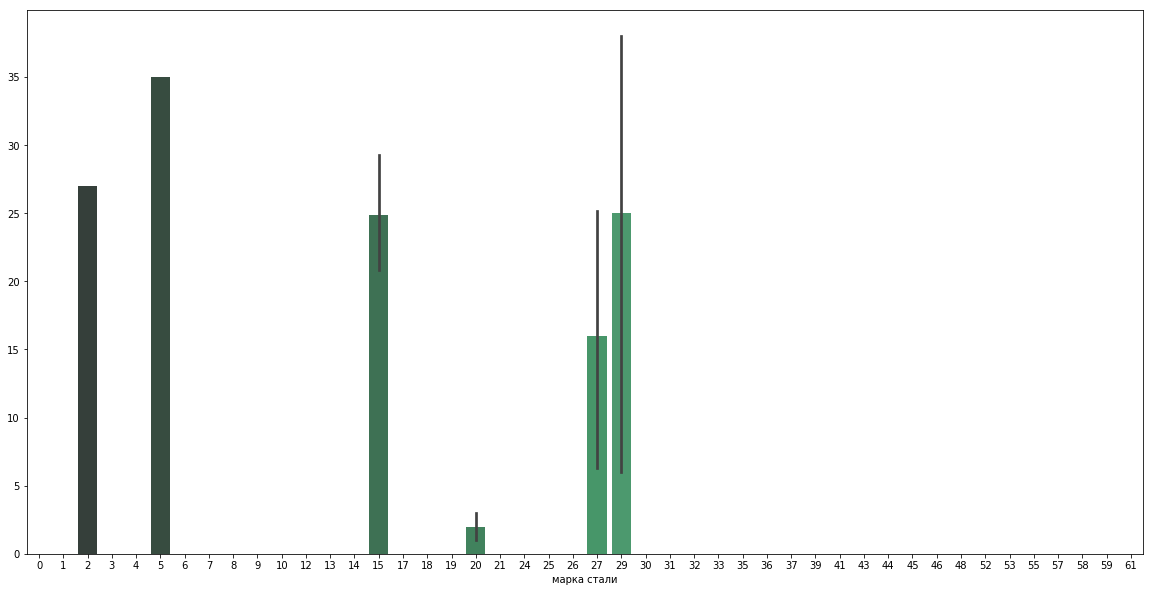

In [303]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

for col in df_prepared_merge.columns[:1]:
    print(col)
    x = df_prepared_merge[col]
    y1 = range(0, len(df_prepared_merge[col].value_counts()))
    sns.barplot(x, y1, palette="BuGn_d")


In [20]:
# '''
# SVR
# '''

# C=1.0
# ratio = 0.9
# seed=17
# epsilon=0.3

# svr_eps = LinearSVR(C = C)

# kfold = model_selection.KFold(n_splits=5, random_state=seed)

# t0 = time.time()
# cv_results = model_selection.cross_val_score(svr_eps, 
#                                              X_train, np.ravel(y_train), cv=kfold, scoring='r2')
# t1 = time.time() - t0
# print(cv_results.mean())
# print(t1)

0.174145449437
13.475857973098755


In [21]:
# '''
# Подбор параметров деревьев решений
# '''
# from sklearn.model_selection import GridSearchCV

# tree = DecisionTreeRegressor()

# tree_params = {'max_depth': range(10,30),'max_features': range(5,20)}

# tree_grid = GridSearchCV(tree, tree_params,cv=5, verbose = True)

# tree_grid.fit(X_train, y_train)
# y_pred_grid = tree_grid.predict(X_test)
# print(tree_grid.best_params_)
# print(tree_grid.best_score_)
# print(mean_absolute_error(y_test, y_pred_grid))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'max_depth': 22, 'max_features': 16}
0.184346892408
3.51187157972


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  2.2min finished


In [22]:
# '''
# Дерево решений
# '''
# tree = DecisionTreeRegressor(max_depth = tree_grid.best_params_['max_depth'], max_features = tree_grid.best_params_['max_features'])
# tree.fit(X_train, y_train)

# y_predicted = tree.predict(X_test)

# scr = tree.score(X_test, y_test)
# mae = mean_absolute_error(y_test, y_predicted)
# print(scr, mae)

-4.02904439516 4.18616107758


In [24]:
# forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=17)
# print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

# forest_params = {'max_depth': range(1,11), 'max_features': range(4,19)}

# forest_grid = GridSearchCV(forest, forest_params, cv=5, verbose=True)

# forest_grid.fit(X_train, y_train)
# y_pred_grid = forest_grid.predict(X_test)
# print(forest_grid.best_params_)
# print(forest_grid.best_score_)
# print(mean_absolute_error(y_test, y_pred_grid))

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.324043674676
Fitting 5 folds for each of 150 candidates, totalling 750 fits


C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 17.2min finished
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 8, 'max_features': 6}
0.465330919591
2.83069259541


In [25]:
# forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=17)
# tree = DecisionTreeRegressor(max_depth = forest_grid.best_params_['max_depth'], 
#                              max_features = forest_grid.best_params_['max_features'])
# estimators = [
#     forest,
#     tree
# ]

# for est in estimators:
#     bagging = BaggingRegressor(est,n_estimators=100, bootstrap=True, bootstrap_features=True)

#     bagging.fit(X_train, y_train)
#     y_pred = bagging.predict(X_test)
#     scr = bagging.score(X_test, y_test)
#     mae = mean_absolute_error(y_test, y_pred)
#     print(scr, mae)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.307558494245 2.67651568369


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.364780510816 2.89249337515


In [26]:
# # Сделаем инициализацию параметров, по которым хотим сделать полный перебор
# parameters = {'max_features': [12,15], 'min_samples_leaf': [2,3], 'max_depth': [12,15], 
#               'n_estimators':[500,1000]}
# rfc = RandomForestRegressor(random_state=42, 
#                              n_jobs=-1, oob_score=True)
# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
# gcv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.0min finished
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [12, 15], 'min_samples_leaf': [2, 3], 'max_depth': [12, 15], 'n_estimators': [500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [27]:
# y_predicted = gcv.predict(X_test)

# mae = mean_absolute_error(y_test, y_predicted)
# mse = mean_squared_error(y_test, y_predicted)
# print(gcv.best_estimator_, 'r2 = ', gcv.best_score_, 'mae = ', mae, 'mse =', mse)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False) r2 =  0.428224853422 mae =  2.62984821274 mse = 185.823787831


array([[ 1.00413529,  1.00263618,  1.00695396, ..., -0.52750024,
         0.40814083, -0.06939041],
       [ 1.99542635,  1.99366535,  1.99427932, ...,  2.61139254,
         0.13907012, -0.06939041],
       [-0.4828013 , -0.48390756, -0.47403409, ..., -0.31824072,
        -0.1300006 , -0.06939041],
       ..., 
       [-0.4828013 , -0.48390756, -0.47403409, ..., -0.1089812 ,
        -2.0134956 , -0.06939041],
       [ 1.99542635,  1.99366535,  1.99427932, ...,  2.82065206,
         0.67721155, -0.06939041],
       [-0.4828013 , -0.48390756, -0.47403409, ...,  0.10027832,
         0.67721155, -0.06939041]])

In [ ]:
NN = MLPRegressor(hidden_layer_sizes=(50, 16), activation='tanh', solver='sgd', 
                  alpha=0.01, batch_size=512, learning_rate='adaptive', 
                  learning_rate_init=0.01, power_t=0.7, 
                  max_iter=10000, tol=1e-15, verbose=True)

NN.fit(X_train, y_train)

y_pred = NN.predict(X_test)

scr = NN.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print(scr, mae)

In [ ]:
X_train.shape

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

kfold = model_selection.KFold(n_splits=5, random_state=seed)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.4))
# model.add(Dense(units=8, input_dim=X.shape[1]))
# model.add(Activation('sigmoid'))

# model.add(Dense(units=4))
# model.add(Activation('sigmoid'))

model.add(Dense(units=1))

model.compile(
    loss=keras.losses.mean_squared_error,
    # loss=keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_error],
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=1e-1)
    )

model.fit(X_train, y_train, epochs=1000)

# cv_results = model_selection.cross_val_score(svr,X_train, np.ravel(y_train), cv=kfold, scoring='r2')

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

kfold = model_selection.KFold(n_splits=5, random_state=seed)

model = Sequential()
model.add(Dense(units=8, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
# model.add(Dropout(0.4))
# model.add(Dense(units=8, input_dim=X.shape[1]))
# model.add(Activation('sigmoid'))

# model.add(Dense(units=4))
# model.add(Activation('sigmoid'))

model.add(Dense(units=1))

model.compile(
    loss=keras.losses.mean_squared_error,
    # loss=keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_error],
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=1e-1)
    )

model.fit(X_train, y_train, epochs=1000)

# cv_results = model_selection.cross_val_score(svr,X_train, np.ravel(y_train), cv=kfold, scoring='r2')

y_predict = model.predict(X_test)
mae = mean_absolute_error(y_predict, y_test)
print(mae)

In [ ]:
import seaborn as sns
# будем отображать графики прямо в jupyter'e
%pylab inline

#увеличим дефолтный размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 20

In [ ]:
sns.set(style="ticks", color_codes=True)


sns_plot = sns.pairplot(df_merge, hue='Врем. сопротивление', size=10)
sns_plot.savefig('pairplot_прочность.png')

In [ ]:
corr_matrix = df_merge.corr()
sns_corr = sns.heatmap(corr_matrix).get_figure()
sns_corr.savefig('corr_прочность.png')

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test) 
accuracy = mean_absolute_error(y_test, y_pred)
print(accuracy)


In [126]:
tips = pd.DataFrame(y_test) 
tips['Предсказанное'] = y_pred_grid
tips.head()

,Врем. сопротивление,Предсказанное
9094,97.000000,96.818939
21405,94.272764,96.896595
25537,79.500000,83.375402
21389,74.592241,76.824856
3149,73.776468,76.469860


In [173]:
# for x in tips['Врем. сопротивление']:
#     try:
#         x = float(x)
#     except:
#         print(x)

# tips['Врем. сопротивление'] = tips['Врем. сопротивление'].apply(lambda x: float(x))

In [175]:
# y_test.head()

,Врем. сопротивление,Предсказанное
13680,78.500000,80.053189
15902,74.388298,77.290237
7367,71.278163,75.488428
10455,71.991965,75.731477
15796,77.141532,75.696999


In [127]:
import seaborn as sns; 
sns.set(color_codes=True)
ax = sns.regplot(x=tips['Врем. сопротивление'], y=tips['Предсказанное'], data=tips)

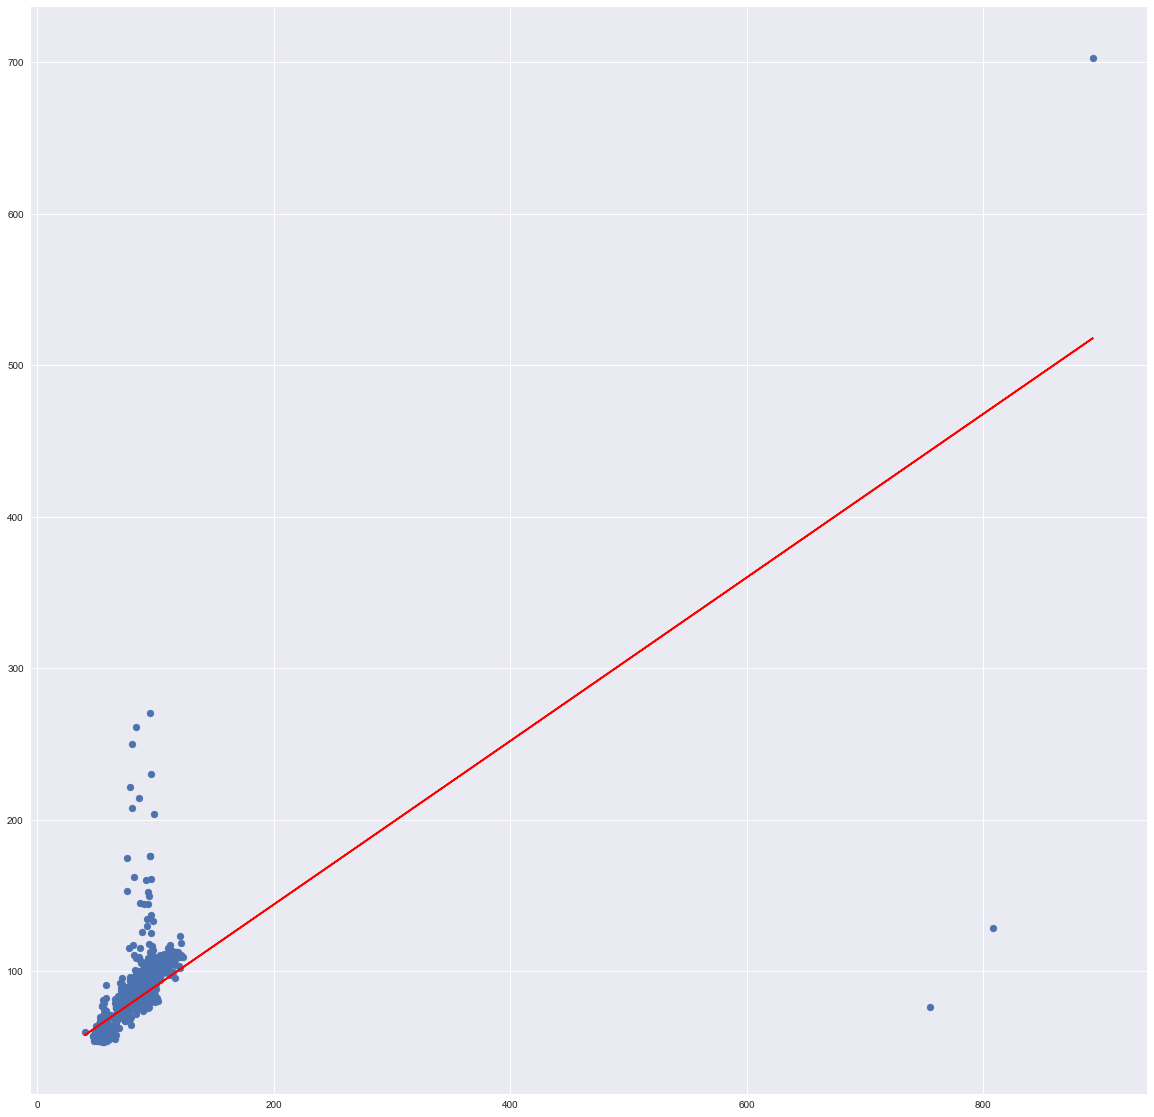

In [152]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 20, 20

# x = tips['Врем. сопротивление']
# y = tips['Предсказанное']
# fig, ax = plt.subplots()
# fit = np.polyfit(x, y, deg=1)
# ax.plot(x, fit[0] * x + fit[1], color='red')
# ax.scatter(x, y)

